## Lib Import

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, roc_curve, accuracy_score

## File Declaration

In [8]:
train_file = "dm.csv"
test_file = "dm_test.csv"

## Data Prep and Feature Eng

In [9]:
# Calculate variance features
def calculate_variance_features(df, window_size):
    for col in ['y1', 'y2', 'y3']:
        df[f'{col}_variance'] = df[col].rolling(window=window_size).var()
    return df

# Calculate standard deviation features
def calculate_std_features(df, window_size):
    for col in ['y1', 'y2', 'y3']:
        df[f'{col}_std'] = df[col].rolling(window=window_size).std()
    return df

# Calculate range features
def calculate_range_features(df, window_size):
    for col in ['y1', 'y2', 'y3']:
        df[f'{col}_range'] = df[col].rolling(window=window_size).max() - df[col].rolling(window=window_size).min()
    return df

# Calculate entropy features
def calculate_entropy_features(df, window_size):
    for col in ['y1', 'y2', 'y3']:
        def entropy(signal):
            _, counts = np.unique(signal, return_counts=True)
            probs = counts / len(signal)
            return - np.sum(probs * np.log2(probs))
        df[f'{col}_entropy'] = df[col].rolling(window=window_size).apply(entropy)
    return df

# Calculate correlation features
def calculate_correlation_features(df, window_size):
    for i, col1 in enumerate(['y1', 'y2', 'y3']):
        for j, col2 in enumerate(['y1', 'y2', 'y3']):
            if i < j:
                df[f'{col1}_{col2}_correlation'] = df[col1].rolling(window=window_size).corr(df[col2])
    return df

# Load the data
train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)

train_data.drop(['Timestamp'], axis=1, inplace=True)
test_data.drop(['Timestamp'], axis=1, inplace=True)

# Add features to train and test data
window_size = 20
train_data = calculate_variance_features(train_data, window_size)
train_data = calculate_std_features(train_data, window_size)
train_data = calculate_range_features(train_data, window_size)
train_data = calculate_entropy_features(train_data, window_size)
train_data = calculate_correlation_features(train_data, window_size)

test_data = calculate_variance_features(test_data, window_size)
test_data = calculate_std_features(test_data, window_size)
test_data = calculate_range_features(test_data, window_size)
test_data = calculate_entropy_features(test_data, window_size)
test_data = calculate_correlation_features(test_data, window_size)


# Drop rows with NaN values resulting from shifting
train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

X_train = train_data.drop(columns=['label'])
y_train = train_data['label']
X_test = test_data.drop(columns=['label'])
y_test = test_data['label']

# Initialize the scaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Train and Eval

model_name 	 accuracy 	 precision 	 recall 	 f1 	 auc
Logistic Regression	0.74	0.54	0.92	0.68	0.79
Random Forest	0.95	0.89	0.95	0.92	0.95
Gradient Boosting	0.94	0.85	0.95	0.90	0.94


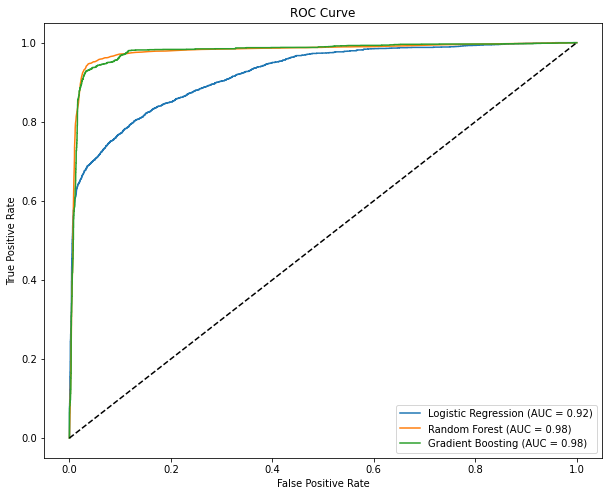

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, roc_curve, accuracy_score
import matplotlib.pyplot as plt

# Initialize models
lr = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier(n_estimators=100)
gb = GradientBoostingClassifier(n_estimators=100)

# Train models
lr.fit(X_train, y_train)
rf.fit(X_train, y_train)
gb.fit(X_train, y_train)

# Predict
y_pred_lr = lr.predict(X_test)
y_pred_rf = rf.predict(X_test)
y_pred_gb = gb.predict(X_test)


def evaluate_model(y_test, y_pred, model_name):
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    auc = roc_auc_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name}\t{accuracy:.2f}\t{precision:.2f}\t{recall:.2f}\t{f1:.2f}\t{auc:.2f}")

print(f"model_name \t accuracy \t precision \t recall \t f1 \t auc")
evaluate_model(y_test, y_pred_lr, "Logistic Regression")
evaluate_model(y_test, y_pred_rf, "Random Forest")
evaluate_model(y_test, y_pred_gb, "Gradient Boosting")

# ROC Curve
def plot_roc_curve(model, X_test, y_test, model_name):
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc_score(y_test, y_prob):.2f})")

plt.figure(figsize=(10, 8))
plot_roc_curve(lr, X_test, y_test, "Logistic Regression")
plot_roc_curve(rf, X_test, y_test, "Random Forest")
plot_roc_curve(gb, X_test, y_test, "Gradient Boosting")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


## Viz test results

In [11]:
# Assuming 'test_file' and 'window_size' are defined
dft = pd.read_csv(test_file)
dft['Timestamp'] = pd.to_datetime(dft['Timestamp'], format='%d-%b-%Y %H:%M:%S')
dft = dft.iloc[window_size-1:]  # Remove window initial data
label_dft = dft[dft['label'] == 1]
ranges = []

# Find contiguous ranges of true labels
start = None
for i in range(len(label_dft)):
    if start is None:
        start = label_dft['Timestamp'].iloc[i]
    if i == len(label_dft) - 1 or label_dft['Timestamp'].iloc[i] != label_dft['Timestamp'].iloc[i + 1]:
        end = label_dft['Timestamp'].iloc[i]
        ranges.append((start, end))
        start = None

# Find contiguous ranges of predicted labels
dft['pred'] = y_pred_rf  # Assuming 'y_pred_rf' is defined
label_dft_pred = dft[dft['pred'] == 1]
rangesTest = []
start = None
for i in range(len(label_dft_pred)):
    if start is None:
        start = label_dft_pred['Timestamp'].iloc[i]
    if i == len(label_dft_pred) - 1 or label_dft_pred['Timestamp'].iloc[i] != label_dft_pred['Timestamp'].iloc[i + 1]:
        end = label_dft_pred['Timestamp'].iloc[i]
        rangesTest.append((start, end))
        start = None

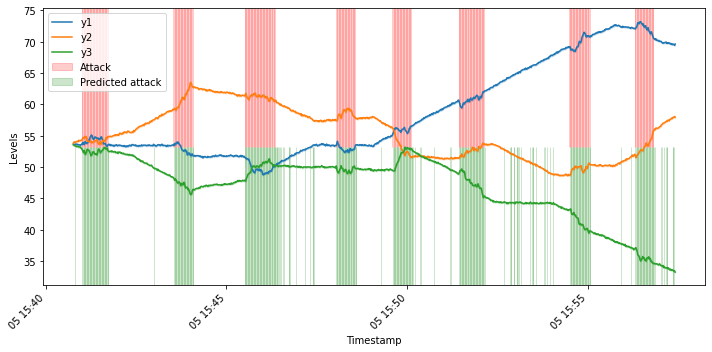

In [12]:
# Define pastel colors
pastel_colors = sns.color_palette("Set2", 5)

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))

# First row
sns.lineplot(x='Timestamp', y='y1', data=dft, ax=ax, label='y1', )
sns.lineplot(x='Timestamp', y='y2', data=dft, ax=ax, label='y2', )
sns.lineplot(x='Timestamp', y='y3', data=dft, ax=ax, label='y3', )

for start, end in ranges:
    ax.axvspan(start, end, 0.5, 1, alpha=0.2, color="red")

for start, end in rangesTest:
    ax.axvspan(start, end, 0, 0.5, alpha=0.2, color="green")

attack_patch = Patch(color='red', alpha=0.2, label='Attack')
attack_pred_patch = Patch(color='green', alpha=0.2, label='Predicted attack')
handles, labels = ax.get_legend_handles_labels()
handles.append(attack_patch)
handles.append(attack_pred_patch)
labels.append('Attack')
labels.append('Predicted attack')
ax.legend(handles=handles, labels=labels)
ax.set_ylabel("Levels")

# Adjusting the x-axis format
for label in ax.get_xticklabels():
    label.set_rotation(45)
    label.set_horizontalalignment('right')

# Adjust layout
plt.tight_layout()
plt.show()
